# Notebook examples for Chapter 3

### Power spectrum of an image band

In [ ]:
import warnings
# these are innocuous but irritating
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
%matplotlib inline

C:\Users\kyang\AppData\Local\Temp\ipykernel_7996\2220015193.py:21: RuntimeWarning: invalid value encountered in power
  image1 = (-1)**(i+j)*image


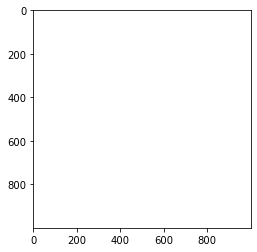

In [2]:
import numpy as np
from numpy import fft
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly
import matplotlib.pyplot as plt

gdal.AllRegister()
infile = 'imagery_initial/AST_20070501'
                  
inDataset = gdal.Open(infile,GA_ReadOnly)     
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    

band = inDataset.GetRasterBand(3)  
image = band.ReadAsArray(0,0,cols,rows)
#  arrays of i and j values    
a = np.reshape(range(rows*cols),(rows,cols))
i = a % cols
j = a / cols
#  shift Fourier transform to center    
image1 = (-1)**(i+j)*image
#  compute power spectrum and display    
image1 = np.log(np.abs(fft.fft2(image1))**2)
mn = np.amin(image1)
mx = np.amax(image1)
plt.imshow((image1-mn)/(mx-mn), cmap='gray')   

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter3/fig3_1.eps')

### Image compression with the Haar wavelet

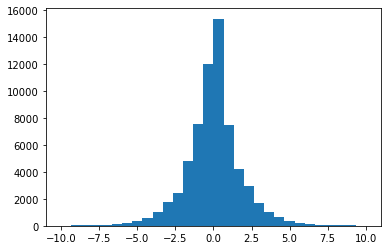

In [3]:
# The Haar mother wavelet
def psi_m(x):
    if x<0:return 0.0 
    elif x<=0.5:return 1.0
    elif x<=1.0:return -1.0
    else:return 0.0
# The Haar basis functions   
def psi(m,k,n):
    c = 2**n
    result = np.zeros(c)
    x = np.linspace(0,1,num=c)
    for i in range(c):
        result[i] = psi_m((2**m)*x[i]-k)
    return result

# Generate wavelet basis B_8
n = 8
B = np.ones((2**n,2**n))
i = 1
for m in range(n):
    for k in range(2**m):
        B[:,i] = psi(m,k,n)
        i += 1
B = np.mat(B)  

# 256x256 subset
G = np.mat(image[200:456,200:456])

# Wavelet transformation
Gw = np.mat(np.zeros((256,256)))
# Filter the columns
for j in range(256):
    Gw[:,j] = B.I*G[:,j]
# Filter the rows    
for i in range(256):
    Gw[i,:] = (B.I*Gw[i,:].T).T
# Histogram of wavelet coefficients    
Gw = np.array(Gw).ravel()
p = plt.hist(Gw,bins=30,range=(-10,10))

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter3/fig3_6.eps')

In [ ]:
# Truncate and reshape
Gw = np.reshape(np.where(np.abs(Gw)<2,0,Gw),(256,256))
# Invert the transformation
Gw = np.mat(Gw)
Gc = np.mat(np.zeros((256,256)))
for i in range(256):
    Gc[i,:] = (B*Gw[i,:].T).T
for j in range(256):    
    Gc[:,j] = B*Gc[:,j]
f, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(np.array(G)/255,cmap='gray')
ax[1].imshow(np.array(Gc)/255,cmap='gray')

#f.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter3/fig3_7.eps',bbox_inches='tight')

In [ ]:
from scipy import sparse

sG = sparse.csr_matrix(G)
sGw = sparse.csr_matrix(Gw)
print sG.data.nbytes
print sGw.data.nbytes

### The cascade algorithm

In [ ]:
def F(x,i,c):
    if i==0:
        if x==0:
            return 1.0
        else:
            return 0.0
    else:
        return c[0]*F(2*x,i-1,c)+c[1]*F(2*x-1,i-1,c) \
              +c[2]*F(2*x-2,i-1,c)+c[3]*F(2*x-3,i-1,c) \
              +c[4]*F(2*x-4,i-1,c)
            
# Haar refinement coefficients
c = np.zeros(5)
c[0] = 1.0; c[1] = 1.0

# fourth order approximation
n = 4
x = np.array(range(4*2**n))/float(2**n)
FF = np.zeros(4*2**n)
for i in range(4*2**n):
    FF[i] = F(x[i],n,c)
    
plt.plot(x,FF)    
plt.ylim(-1,2)

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter3/fig3_8.eps')

In [ ]:
# Daubechies D4 refinement coeffificents
c = np.zeros(5)
c[0] = (1+np.sqrt(3))/4; c[1] = (3+np.sqrt(3))/4
c[2] = (3-np.sqrt(3))/4; c[3] = (1-np.sqrt(3))/4
c[4] = 0.0

for i in range(4*2**n):
    FF[i] = F(x[i],n,c)
    
plt.plot(x,FF)    
plt.ylim(-1,2)

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter3/fig3_9.eps')

### Principal components

In [ ]:
import ee
from ipyleaflet import (Map,DrawControl,TileLayer)
from auxil import eepca
ee.Initialize()

# function for overlaying tiles onto a map
def GetTileLayerUrl(ee_image_object):
  map_id = ee.Image(ee_image_object).getMapId()
  tile_url_template =  "https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}"
  return tile_url_template.format(**map_id)

# get the image
im = ee.Image(
  'LANDSAT/LE07/C01/T1_RT_TOA/LE07_197025_20010626') \
              .select('B1','B2','B3','B4','B5','B7')

# perform principal components analysis
pcs, lambdas = eepca.pca(im) 

# display the default base map and overlay the PCA image
m = Map(center=[50.7, 6.4], zoom=7)

m.add_layer(TileLayer(url=GetTileLayerUrl(
        pcs.select('pc1','pc2','pc3') \
       .visualize(min=-0.1, max=0.1, opacity = 1.0)
    )
))

m

In [ ]:
gdexporttask = ee.batch.Export.image.toDrive(pcs,
               description='driveExportTask', 
               folder='EarthEngineImages',
               fileNamePrefix='PCS',
               scale=30,
               maxPixels=1e9) 
gdexporttask.start()              

In [ ]:
run scripts/ex3_1

In [ ]:
run scripts/pca -r 2 -n imagery/LE7_20010626

In [ ]:
%run scripts/dispms -f imagery/LE7_20010626 -p [1,2,3] -e 2 \
-F imagery/LE7_20010626_recon -P [1,2,3] -E 2 
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter3/fig3_11.eps'

### Dual solution

In [ ]:
# column-centered data matrix for random 2D data
G = np.mat(2*np.random.rand(100,2))-1
# covariance matrix
S = G.T*G/99
# Gram matrix
K = G*G.T
lambda_s, _ = np.linalg.eigh(S)
lambda_k, _ = np.linalg.eigh(K)
# sort eigenvalues in decreasing oder
idx = np.argsort(lambda_s)[::-1]
lambda_s = lambda_s[idx]
idx = np.argsort(lambda_k)[::-1]
lambda_k = lambda_k[idx]
# compare
print lambda_s
print lambda_k[0:3]/99

In [ ]:
run scripts/ex3_2 imagery/LE7_20010626

### Minimum noise fraction

In [ ]:
run scripts/mnf -n imagery/LE7_20010626

In [ ]:
run scripts/dispms -f imagery/LE7_20010626_mnf -p [3,1,2] -e 4 \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter3/fig3_12.eps' 

#### Excercise 13

In [ ]:
# a 2D two-class image
n1 = np.random.randn(1000)
n2 = n1 + np.random.randn(1000)
B1 = np.zeros((1000,2))
B2 = np.zeros((1000,2))
B1[:,0] = n1
B1[:,1] = n2
B2[:,0] = n1+4
B2[:,1] = n2
G = np.concatenate((B1,B2))
# center the image
G[:,0] = G[:,0] - np.mean(G[:,0])
# estimate covariance and diagonalize
C = np.mat(G).T*np.mat(G)/2000
_,U = np.linalg.eigh(C)
# slopes of the principal axes
s1 = U[1,1]/U[0,1]
s2 = U[1,0]/U[0,0]
# plot
plt.xlim((-5,5))
plt.ylim((-5,5))
plt.axes().set_aspect(1)
plt.plot(G[:,0],G[:,1],'b.',
         [-5,5],[-5*s1,5*s1],'k',
         [-5,5],[-5*s2,5*s2],'k')

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter3/fig3_13.eps',bbox_inches='tight')